# Demographic Information
1. Gender Ratio
2. Age Distribution
3. Proportions of Drinking and Smoking

In [7]:
import pandas as pd
df = pd.read_csv('/home/ubuntu/proj/rt-dataset/src/data/demographic.csv')
df = df[['export_id', 'age', 'gender', 'smoke', 'drink']]
df['age'] = pd.to_numeric(df['age'], errors='coerce')

print(f'Number of rows: {df.shape[0]}')
print(f'Gender: \n{df.gender.value_counts()}')
print(f'Age: \nmean: {df.age.mean()} \nstd: {df.age.std()}')
df.head()

Number of rows: 24292
Gender: 
female    15545
male       8747
Name: gender, dtype: int64
Age: 
mean: 20.65573028157418 
std: 2.4087126611000023


,export_id,age,gender,smoke,drink
0,61793,19.0,female,never smokes,never drinks
1,61809,18.0,female,never smokes,never drinks
2,61737,40.0,male,never smokes,drinks occasionally (less than once a week)
3,61738,23.0,female,never smokes,never drinks
4,61739,21.0,female,never smokes,never drinks


# Scale Scores
1. Distribution of Scale Scores
2. Correlation Between Different Scale Scores

In [8]:
import pandas as pd
import numpy as np

from data import Data

scale_list = ['phq9', 'isi', 'gad7', 'pss']
phq9, gad7, isi, pss = Data('phq9'), Data('gad7'), Data('isi'), Data('pss')

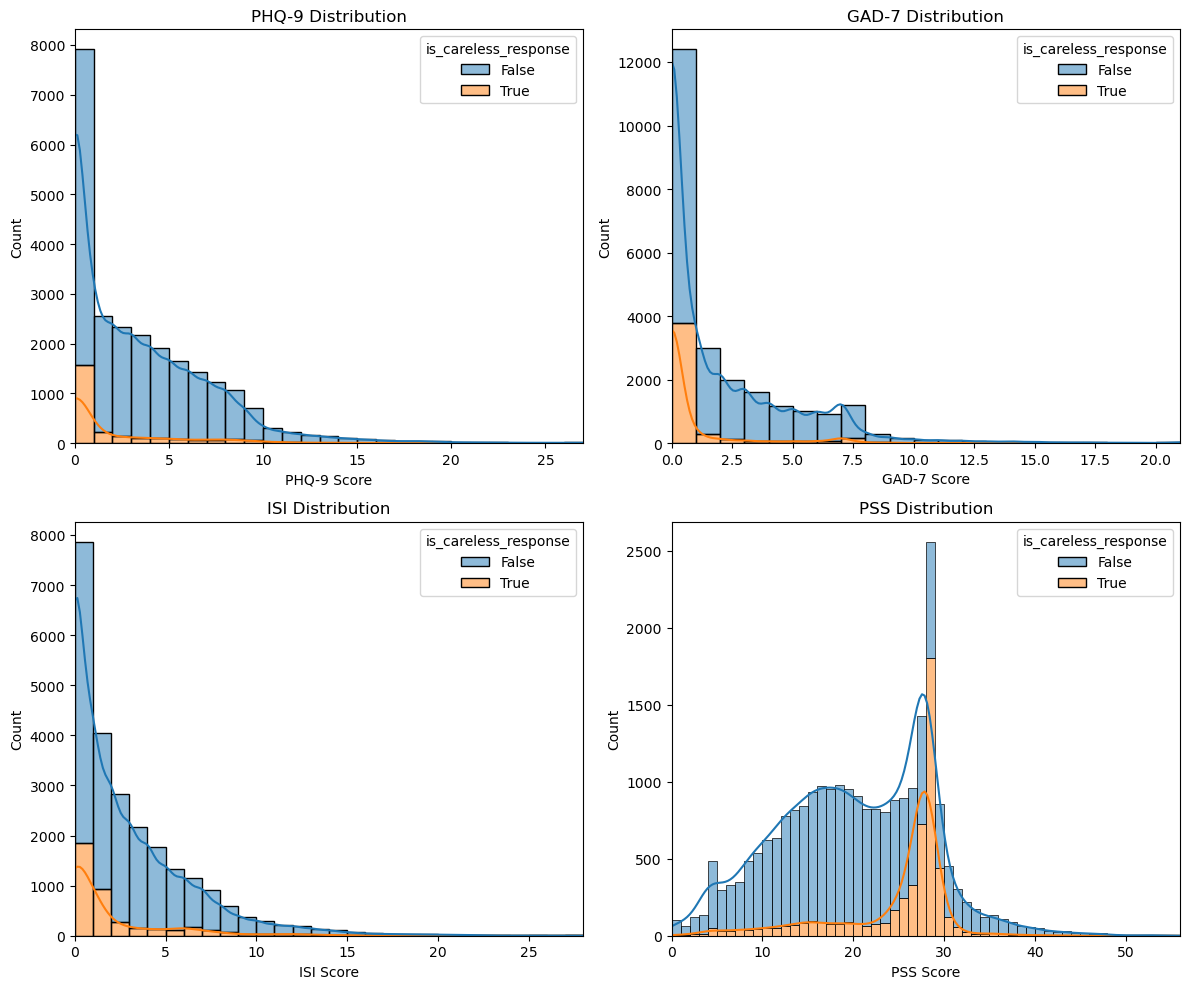

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

def histplot(df, name, ax):
    sns.histplot(data=df, x='score', kde=True, hue='is_careless_response', multiple='stack', bins=np.max(df['score']), ax=ax)
    ax.set_xlim(0, np.max(df['score']))
    ax.set_title(f'{name} Distribution')
    ax.set_xlabel(f'{name} Score')
    ax.set_ylabel('Count')

histplot(phq9.df, 'PHQ-9', axes[0, 0])
histplot(gad7.df, 'GAD-7', axes[0, 1])
histplot(isi.df, 'ISI', axes[1, 0])
histplot(pss.df, 'PSS', axes[1, 1])

plt.tight_layout()
plt.show()

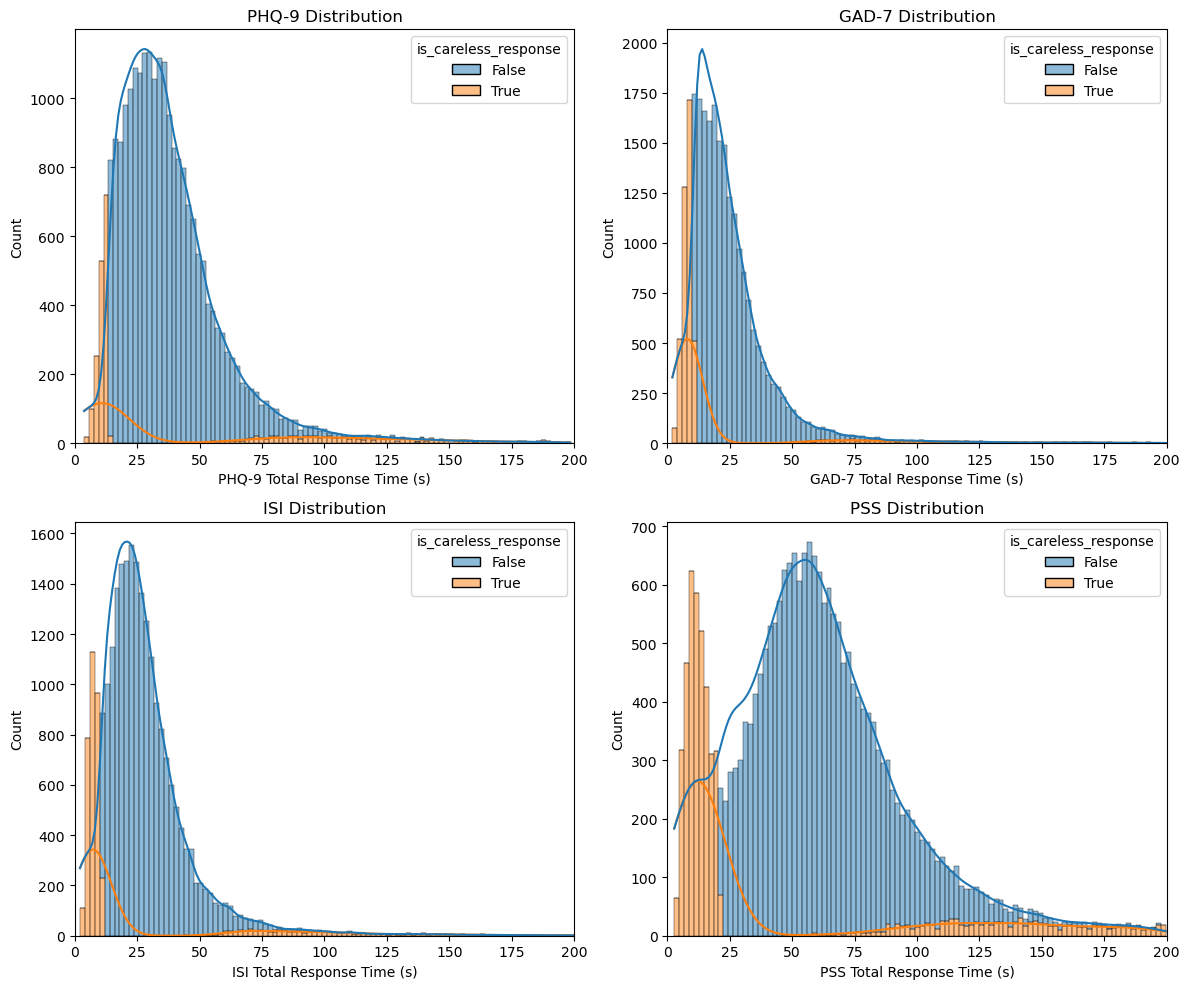

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

def histplot(df, name, ax):
    sns.histplot(data=df.query('total_response_time < 200'), x='total_response_time', hue='is_careless_response', \
                 multiple='stack', kde=True, bins=100, ax=ax)
    ax.set_xlim(0, 200)
    ax.set_title(f'{name} Distribution')
    ax.set_xlabel(f'{name} Total Response Time (s)')
    ax.set_ylabel('Count')

histplot(phq9.df, 'PHQ-9', axes[0, 0])
histplot(gad7.df, 'GAD-7', axes[0, 1])
histplot(isi.df, 'ISI', axes[1, 0])
histplot(pss.df, 'PSS', axes[1, 1])

plt.tight_layout()
plt.show()

In [11]:
def statsum(df, name):

    print(f'After remove CR, {name} score')
    print(f'mean: {np.mean(df.score)}')
    print(f'std: {np.std(df.score)}')

    print(f'After remove CR, {name} total response time')
    print(f'mean: {np.mean(df.total_response_time)}')
    print(f'std: {np.std(df.total_response_time)}')

statsum(phq9.df.query('is_careless_response == False'), 'PHQ-9')
statsum(gad7.df.query('is_careless_response == False'), 'GAD-7')
statsum(isi.df.query('is_careless_response == False'), 'ISI')
statsum(pss.df.query('is_careless_response == False'), 'PSS')

After remove CR, PHQ-9 score
mean: 3.4189619377162628
std: 3.697865007293027
After remove CR, PHQ-9 total response time
mean: 37.471362399077364
std: 17.299654252958213
After remove CR, GAD-7 score
mean: 2.1772998927312663
std: 2.9877719160333753
After remove CR, GAD-7 total response time
mean: 25.306817694233022
std: 12.509679105214508
After remove CR, ISI score
mean: 2.9389233954451344
std: 3.442613627397756
After remove CR, ISI total response time
mean: 28.474790002957686
std: 13.202734706843838
After remove CR, PSS score
mean: 18.72322934232715
std: 8.329103621820165
After remove CR, PSS total response time
mean: 63.88724810286692
std: 26.300214970580097


In [13]:
import pandas as pd
from scipy.stats import pearsonr
from itertools import combinations


def merge(df_list, on='export_id'):
    df = df_list[0]
    for i in range(1, len(df_list)):
        df = pd.merge(df, df_list[i], on=on)
    return df

# is_careless_response == False
df_list = [phq9.df.query('is_careless_response == False')[['export_id', 'score']], \
           gad7.df.query('is_careless_response == False')[['export_id', 'score']], \
            isi.df.query('is_careless_response == False')[['export_id', 'score']], \
            pss.df.query('is_careless_response == False')[['export_id', 'score']]]

# df_list = [phq9.df[['export_id', 'score']], \
#               gad7.df[['export_id', 'score']], \
#                 isi.df[['export_id', 'score']], \
#                 pss.df[['export_id', 'score']]]

df = merge(df_list).drop(columns=['export_id'])

# rename columns
df.columns = ['phq9', 'gad7', 'isi', 'pss']

corr = pd.DataFrame(columns=['phq9', 'gad7', 'isi', 'pss'], index=['phq9', 'gad7', 'isi', 'pss'])

# calculate correlation
for column1, column2 in combinations(df.columns, 2):
    r, p = pearsonr(df[column1], df[column2])
    if p < 0.0001:
        corr.loc[column2, column1] = str(round(r, 3)) + '***'
    elif p < 0.001:
        corr.loc[column2, column1] = str(round(r, 3)) + '**'
    elif p < 0.01:
        corr.loc[column2, column1] = str(round(r, 3)) + '*'

corr.to_csv('results/correlation.csv')

/tmp/ipykernel_3616575/2746536402.py:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'score_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df_list[i], on=on)
